In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, explained_variance_score, accuracy_score

In [11]:
from skmixed.lme.problems import LinearLMEProblem
from skmixed.lme.oracles import LinearLMEOracle
from skmixed.lme.models import LinearLMESparseModel
from skmixed.lme.trees import Tree

## Choosing information criterion

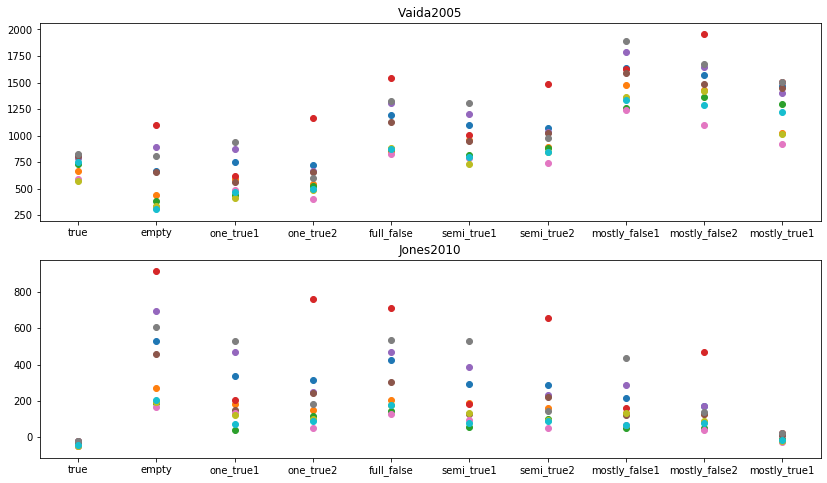

In [10]:
fig = plt.figure(figsize(14, 8))
grid = plt.GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, :])
ax1.set_title("Vaida2005")
ax2.set_title("Jones2010")

for seed in tqdm(range(10)):

    problem, true_parameters = LinearLMEProblem.generate(groups_sizes=[40, 30, 50],
                                                        features_labels=[3, 3, 6, 5, 5, 6],
                                                        random_intercept=True,
                                                        obs_std=0.1,
                                                        seed=seed)
    true_beta = true_parameters['beta']
    true_gamma = true_parameters['gamma']

    correctly_pivoted_problem = problem.pivot((0, 2, 3))
    correct_oracle = LinearLMEOracle(correctly_pivoted_problem)
    jones2010bic_ref = correct_oracle.jones2010bic(true_beta, true_gamma)
    vaida2005aic_ref = correct_oracle.vaida2005aic(true_beta, true_gamma)

    features_idxs = {
        "true": (0, 2, 3),
        "empty": (0, ),
        "one_true1": (0, 2), 
        "one_true2": (0, 3), 
        "full_false": (0, 1, 4),
        "semi_true1": (0, 1, 2),
        "semi_true2": (0, 3, 4),
        "mostly_false1": (0, 1, 2, 4),
        "mostly_false2": (0, 1, 3, 4),
        "mostly_true1": (0, 2, 3, 4),
    }


    vaida2005aics = []
    jones2010bics = []
    labels = []
    for label, categorical_feature_idx in features_idxs.items():
        pivoted_problem = problem.pivot(categorical_feature_idx)
        X, y = pivoted_problem.to_x_y()
        model = LinearLMESparseModel(lb=0, lg=0, initializer="EM") # no regularization 
        model.fit(X, y)
        pred_beta = model.coef_['beta']
        pred_gamma = model.coef_['gamma']
        oracle = LinearLMEOracle(pivoted_problem)
        vaida2005aics.append(oracle.vaida2005aic(pred_beta, pred_gamma))
        jones2010bics.append(oracle.jones2010bic(pred_beta, pred_gamma))
        labels.append(label)
        
    ax1.scatter(labels, vaida2005aics)
    ax2.scatter(labels, jones2010bics)
plt.show()

## Comparing one categorical tree to an indicator fit

In [27]:
mses_tree = []
mses_indicators = []
for j in tqdm(range(50)):
    problem_categorical, true_parameters = LinearLMEProblem.generate(groups_sizes=[40, 30, 50],
                                                                     features_labels=[3, 6, 5, 5, 6],
                                                                     random_intercept=True,
                                                                     obs_std=0.1,
                                                                     seed=j)

    continuous_model = LinearLMESparseModel(lb=0, lg=0, nnz_tbeta=2, nnz_tgamma=2)
    tree_model = Tree(model=continuous_model, max_depth=3)
    tree_model.fit_problem(problem_categorical)
    y_pred_tree = tree_model.predict_problem(problem_categorical)
    x, y_true = problem_categorical.to_x_y()

    column_labels_continuous = [3 if label==5 else label for label in problem_categorical.column_labels][1:]
    problem_indicators = problem_categorical.reconfigure_columns(new_columns_labels=column_labels_continuous)
    continuous_model.fit_problem(problem_indicators)
    y_pred_indicators = continuous_model.predict_problem(problem_indicators)

    explained_variance_tree = explained_variance_score(y_true, y_pred_tree)
    mse_tree = mean_squared_error(y_true, y_pred_tree)

    explained_variance_indicators = explained_variance_score(y_true, y_pred_indicators)
    mse_indicators = mean_squared_error(y_true, y_pred_indicators)
    mses_tree.append(mse_tree)
    mses_indicators.append(mse_indicators)

(0, 6)

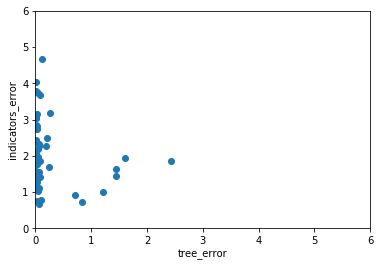

In [31]:
plt.scatter(mses_tree, mses_indicators)
plt.xlabel("tree_error")
plt.ylabel("indicators_error")
plt.xlim((0, 6))
plt.ylim((0, 6))

In [17]:
true_parameters['beta']

array([0.5488135 , 0.71518937])

In [18]:
continuous_model.coef_['beta']

array([ 0.44108476,  0.5278757 ,  1.00900357, -0.01063318, -0.72475138,
       -0.06546275, -0.26109359])

In [20]:
tree_model.fitted_model_.coef_['beta']

array([0.45258439, 1.02203168])